# Assignment 1
## Exercise 3: MNIST k-NN classification
First, I import the packages I'm going to use during the exercise: 
- [numpy](www.numpy.org)
- [matplotlib](http://matplotlib.org) 
- [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) from scipy
- [scikit-learn](https://scikit-learn.org) Used to load and split the data. 

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
# load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

I have splitted data randomly between train and test data and their respective labels with the help of scikit-learn's train_test_split (instead of random.shuffle() and divide the X and y):

In [3]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000)

In [4]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In order to optimize the performance of my model, I had to change my function that calculates the distance so that it takes two matrices as argument. As I did in exercise 1, I wanted to avoid loops as much as possible and wanted to take advantage of numpy's broadcasting. I checked a few ways to calculate the euclidean distance and compare them as done in these articles:

[Optimising pairwise Euclidean distance calculations using Python](https://towardsdatascience.com/optimising-pairwise-euclidean-distance-calculations-using-python-fc020112c984)

[High-Performance computation in Python | NumPy](https://semantive.com/high-performance-computation-in-python-numpy-2/)

So, since I wanted to calculate the distance without using scikit-learn, I decided to compare the time consumed by the following calculations:

- [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) from scipy.
- with the help of the [Einstein summation convention](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)

When timing the computation of the whole train/test sets distances, I got (in my rather old computer) the following times:

cdist

14min 20s ± 1min 35s per loop (mean ± std. dev. of 7 runs, 1 loop each)

einsum

4min 44s ± 19.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

So I decided to use the Einstein summation convention where np.sum(np-power(X_train,2), axis=1) is the same as np.einsum('ij,ij->i', X_train, X_train)

(I got the best performance with euclidean_distances from scikit-learn, but I guess I cannot use it)

In [5]:
def calculate_distance(X_train, X_test):

    #distances = -2 * np.dot(X_test, X_train.T) + np.sum(X_train**2, axis=1) + np.sum(X_test**2, axis=1)[:, np.newaxis]
    #distances = cdist(X_test, X_train)
    #distances = euclidean_distances(X_test, X_train)
    
    distances = np.einsum('ij,ij->i', X_train, X_train) + np.einsum('ij,ij->i', X_test, X_test)[:,np.newaxis] -2 * np.dot(X_test, X_train.T)
    return distances

In my original knn classifier I calculate the distances with each iteration which doesn't result in such great performance. So this time I decided to compute the distances outside the knn function since we are using the same data in each iteration.

In [6]:
def get_sorted_index(X_train, X_test):

    distances = calculate_distance(X_train, X_test)

    sorted_index = np.argsort(distances, axis=1) 
    
    return sorted_index

The knn classifier now returns a list of all the predictions for the test set:

In [7]:
def knn(sorted_index, y_train, k):
    
    predictions = []
    
    for dist in sorted_index: 
        
        # get k nearest neighbours labels
        k_idx = dist[:k]
        closest_neighbours = y_train[k_idx]

        # most common label
        labels, votes = np.unique(closest_neighbours, return_counts=True)
        most_voted_label = np.argmax(votes)

        predictions.append(labels[most_voted_label]) # add the predicted value to list
    
    return predictions

I decide to use accuracy to evaluate my model since it's a widely used metric to evaluate classification. Usually the k-value range is chosen from k=sqrt(n) but in this case it wasn't neccessary to get predictions from so many values as we will see after trying k = (1-25):

In [ ]:
sorted_index = get_sorted_index(X_train, X_test)

accuracy_list=[]

for k in range(1,26,2):
    
    # get predictions of the test set
    predictions = knn(sorted_index, y_train, k)

    # calculate accuracy
    accuracy = (np.sum(np.equal(predictions, y_test) == True) / len(predictions)) * 100

    accuracy_list.append(accuracy)
    
    print(f"k = {k}")
    print(f"Accuracy: {accuracy}")
    print()

I decided to plot the accuracy of the model for the different k-values so that it's easier to analyze the results:

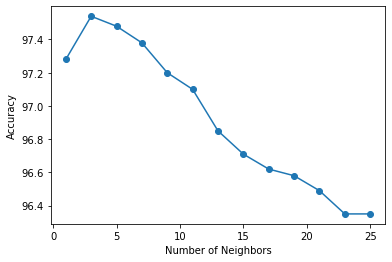

In [124]:
plt.plot(range(1,26,2), accuracy_list, marker="o")
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

As we can see in the figure, I got the best result when k = 3 with 97.54% accuracy which is the same, in this particular case, as the least test error. To check the model for larger values of k wasn't neccessary as the accuracy decreases with larger k values.